# 状態空間モデル

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import requests
import io
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import minimize
from pykalman import KalmanFilter

# 状態空間モデルを構築するのに必要な関数をインポート
from state_space_utils import *

In [2]:
%load_ext autoreload
%autoreload 2

## パラメータの設定

In [3]:
np.set_printoptions(linewidth=1000, precision=2, floatmode='fixed', suppress=True)

result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## データの取得

In [4]:
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
passengers = pd.read_csv(io.StringIO(stream.decode('utf-8')))

In [5]:
passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<AxesSubplot:>

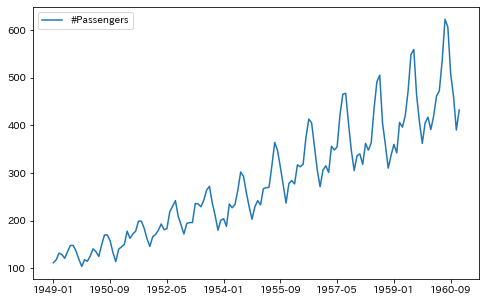

In [6]:
passengers.plot(
    x='Month',
    y='#Passengers', 
    figsize=(8, 5),
    xlabel=''
)

## データの加工

In [7]:
y = pd.Series(
    passengers['#Passengers'].values, 
    index=pd.to_datetime(passengers['Month'], infer_datetime_format=True)
)
y = y.astype(float)

n_train = 120
train_data, test_data = y.values[:n_train], y.values[n_train:]

##  トレンド推定モデル

### パラメータの設定

In [8]:
n_dim_obs = 1                  # 観測値の次元数
n_dim_trend = 2                # トレンドの次元数（状態の次元数）
n_dim_state = n_dim_trend

F = np.array([
    [2, -1],
    [1, 0]
], dtype=float)

G = np.array([
    [1],
    [0]
], dtype=float)

H = np.array([
    [1, 0]
], dtype=float)

Q = np.eye(1) * 10
Q = G.dot(Q).dot(G.T)

state_mean = np.zeros(n_dim_state)              # 状態の平均値ベクトルの初期値
state_cov = np.ones((n_dim_state, n_dim_state)) # 状態の分散共分散行列の初期値

### トレンド推定モデルの構築

In [9]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=state_mean,
    initial_state_covariance=state_cov,
    transition_matrices=F,
    transition_covariance=Q,
    observation_matrices=H,
    observation_covariance=1.0,
)

### 平滑化

In [10]:
state_means, state_covs = kf.smooth(train_data)

In [11]:
print('状態の平均値 : \n{} \n\n 状態の共分散 : \n{}'.format(
    state_means[:4],
    state_covs[:4]
))

状態の平均値 : 
[[ 59.91  59.91]
 [109.58  59.91]
 [130.65 109.58]
 [129.08 130.65]] 

 状態の共分散 : 
[[[0.47 0.47]
  [0.47 0.47]]

 [[0.68 0.09]
  [0.09 0.47]]

 [[0.71 0.16]
  [0.16 0.68]]

 [[0.71 0.17]
  [0.17 0.71]]]


In [12]:
ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)

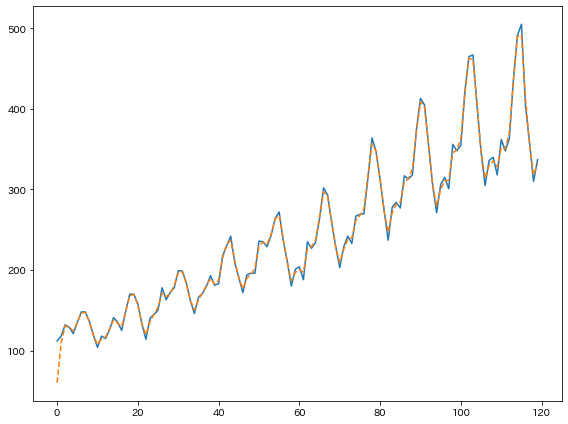

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(train_data, label="observation")
plt.plot(ovsevation_means_predicted, '--', label="forecast")
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('passenger_trend_smooth.png'))

### 予測

In [14]:
train_data, test_data = y[:n_train], y[n_train:]
    
state_means, state_covs = kf.smooth(train_data)
ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)

current_state = state_means[-1]
current_cov = state_covs[-1]

pred_means = np.array([])
for i in range(len(test_data)):

    current_state, current_cov = kf.filter_update(
        current_state, current_cov, observation=None
    )
    pred_mean = kf.observation_matrices.dot(current_state)
    pred_means = np.r_[pred_means, pred_mean]

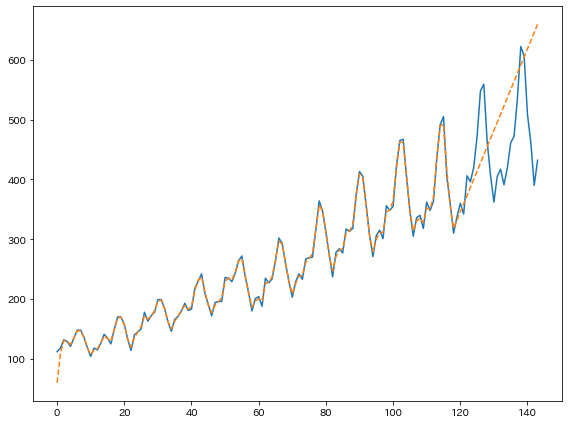

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(y.values, label="observation")
plt.plot(
    np.hstack([
        ovsevation_means_predicted.flatten(), 
        np.array(pred_means).flatten()
    ]), 
    '--', label="forecast"
)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('passenger_trend_predict.png'))

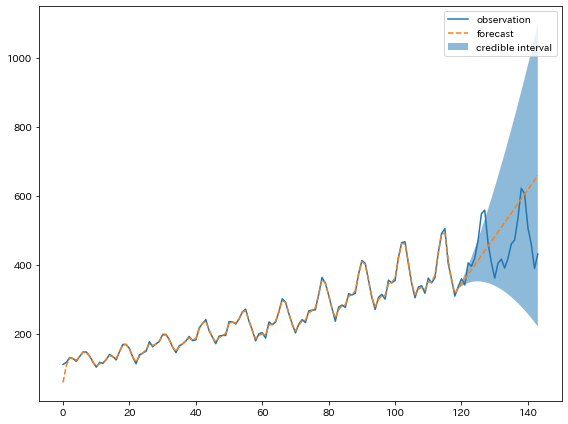

In [16]:
plot_state_space_model_pred(
    kf=kf, y=y.values, n_train=n_train, credible_interval=True,
    img_file_path=result_dir_path.joinpath('passenger_trend_predict.png')
)

## トレンド、季節周期、ARを状態とする状態空間モデル

In [143]:
n_dim_obs = 1
n_dim_trend = 2
n_dim_series = 12
n_dim_ar = 2
Q_sigma = 10

# 状態の遷移行列の設定
F, H, Q, n_dim_state = set_state_space_model_matrixes(
    n_dim_trend=n_dim_trend, 
    n_dim_obs=n_dim_obs, 
    n_dim_series=n_dim_series, 
    n_dim_ar=n_dim_ar,
    Q_sigma=Q_sigma
)

In [144]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=np.ones((n_dim_state, n_dim_state)),
    transition_matrices=F,
    observation_matrices=H,
    observation_covariance=1.0,
    transition_covariance=Q
)

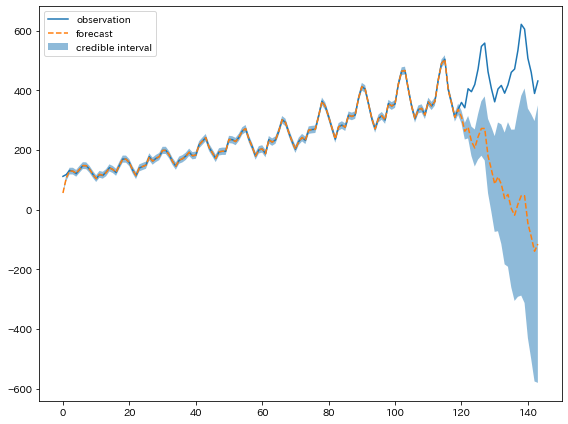

In [145]:
plot_state_space_model_pred(
    kf=kf, y=y.values, n_train=n_train,
    img_file_path=result_dir_path.joinpath('passenger_state_space_predict.png')
)

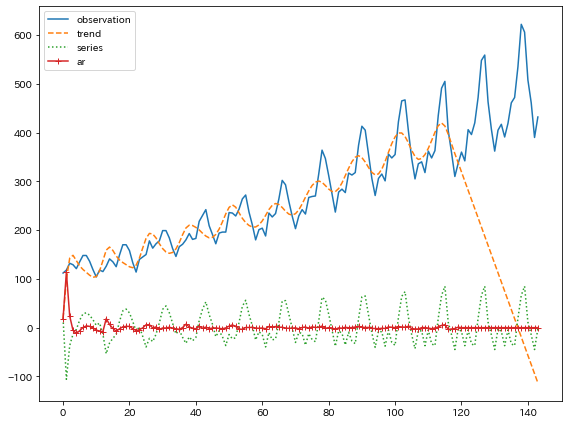

In [146]:
plot_state_space_model_process(
    kf=kf, y=y.values, n_train=n_train, 
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
    img_file_path=result_dir_path.joinpath('passenger_state_space_analysis.png')
)

### パラメータの最適化

In [188]:
n_iter = 5
n_Q = 1 + int(n_dim_series > 0) + int(n_dim_ar > 0)

index_ar_start = n_dim_trend + n_dim_series - 1
bounds_ar = ((-0.95, 0.95), )
bounds_Q = ((1e-4, 1e3), ) * (n_Q - 1) + ((1e-4, 5e1), )

kf_copy = copy.deepcopy(kf)
for index_ar in range(n_dim_ar):
    
    for loop in range(n_iter):
        
        minimize(
            minimize_likelihood_state_space_model, 
            (0.,), 
            args=(kf_copy, train_data, index_ar_start, index_ar_start + index_ar, 'mat'), 
            method='SLSQP', 
            bounds=bounds_ar
        )

        cov_indexes = [index_ar_start, n_dim_trend, 0]
        for i, index in enumerate(cov_indexes):
            
            minimize(
                minimize_likelihood_state_space_model, 
                (0., ), 
                args=(kf_copy, train_data, index, index, 'cov'), 
                method='SLSQP', 
                bounds=(bounds_Q[len(cov_indexes) - i - 1], )
            )
        
        print('AR {} loop [{}/{}], Log Likelifood : {:.2f}'.format(
            index_ar + 1, loop + 1, n_iter, 
            kf_copy.loglikelihood(train_data)
        ))
        
opt_kf = copy.deepcopy(kf_copy)

AR 1 loop [1/5], Log Likelifood : -1353.17
AR 1 loop [2/5], Log Likelifood : -1423.14
AR 1 loop [3/5], Log Likelifood : -1423.14
AR 1 loop [4/5], Log Likelifood : -1423.14
AR 1 loop [5/5], Log Likelifood : -1423.14


/usr/local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


AR 2 loop [1/5], Log Likelifood : -1422.81
AR 2 loop [2/5], Log Likelifood : -1422.45
AR 2 loop [3/5], Log Likelifood : -1422.12
AR 2 loop [4/5], Log Likelifood : -1421.55
AR 2 loop [5/5], Log Likelifood : -1421.13


ARの遷移行列

In [184]:
opt_kf.transition_matrices[index_ar_start: , index_ar_start:]

array([[0.95, 0.06],
       [1.00, 0.00]])

共分散行列の遷移行列

In [195]:
np.diag(opt_kf.transition_covariance)[[0, n_dim_trend, index_ar_start]]

array([   0.00, 1000.00,   50.00])

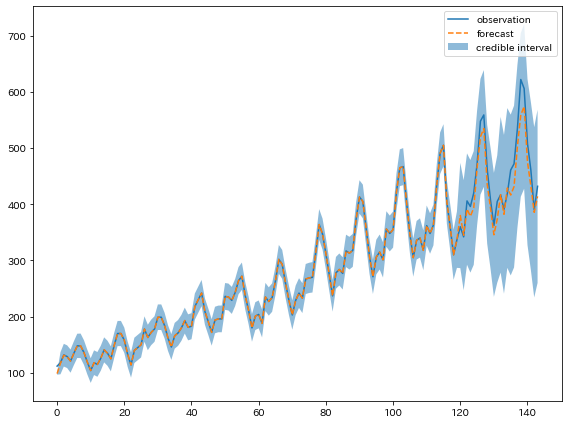

In [186]:
plot_state_space_model_pred(
    kf=opt_kf, y=y.values, n_train=n_train,
    img_file_path=result_dir_path.joinpath('passenger_state_space_opt_predict.png')
)

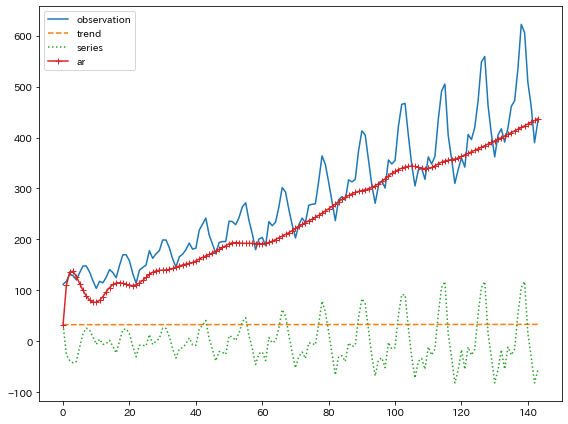

In [187]:
plot_state_space_model_process(
    kf=opt_kf, y=y.values, n_train=n_train, 
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
    img_file_path=result_dir_path.joinpath('passenger_state_space_opt_process.png')
)